# International Debt

In [21]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import wbgapi as wb
from notion_client import APIResponseError
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans

Retrieving the data

In [3]:
# GNI per capita year on year (%) = NY.GNP.PCAP.KD.ZG
# GDP growth year on year (%) = NY.GDP.MKTP.KD.ZG
# GDP per capita (current US$) = NY.GDP.PCAP.CD

# Functions to get indicator data for a country and to return it in formatted JSON
def get_indicator_list(indicator,country_code):
    indicator_list = {}
    try:
        for row in wb.data.fetch(indicator, country_code): # all years
            year = row['time'][2:]
            
            # Only gets years from 2000-2020
            if(int(year) > 2020 or int(year) < 2000): continue

            # If the dataset doesn't have a value it is replaced with NaN as a placeholder, else it appends it to the indicator list
            if row['value'] != None:
                indicator_list[row['time'][2:]] = row['value']
            else:
                indicator_list[row['time'][2:]] = np.nan
    
    # Catches errors so that the code doesn't stop working if the API doesn't connect
    except APIResponseError as err:
        print(f"An APIRespsonse error occured with {country_code} : {err}")
    except Exception as err:
        print(f"An unexpected error occured: {err}")

    return indicator_list

# Uses the fucntion above to get the value of the categories for the three chosen indicators
def get_indicatiors_for_country(country_code):
    indicators_data = {'GNI per capita year on year (%)': get_indicator_list('NY.GNP.PCAP.KD.ZG',country_code),
                       'GDP growth year on year (%)': get_indicator_list('NY.GDP.MKTP.KD.ZG',country_code),
                       'GDP per capita (current US$)': get_indicator_list('NY.GDP.PCAP.CD',country_code)}
    return indicators_data


In [4]:
# Get all the country codes for all the countries
with open(f'./IDS_ALLCountries_Data.json') as f:
    data = json.load(f)
country_codes = []

for i in data:
    country_code = i['Country Code']

    # If the country code is empty or it is already in the 'country_codes' array it continues so ther is no duplicate values
    if country_code in country_codes or country_code == '' : continue
    country_codes.append(country_code)

In [6]:
# Send all the countries indicator data to the directory 'indicators_for_countries_data' as json.
for country_code in country_codes:
    indicator_json = {country_code: get_indicatiors_for_country(country_code)}
    with open(f"indicators_data/{country_code}_indicators", "w") as outfile:
        json.dump(indicator_json, outfile)


Getting the indicator data ready

In [7]:
# Functions to get indicator data for all the countries in the dataset

# Sorts indicator data into dictionaries given a countries code
def get_indicator_data_ready(_country_code):
    
    # Opens the json that has the data for the indicators for the given country
    with open(f"./indicators_data/{_country_code}_indicators") as f:
        json_indicators = json.load(f)
    
    country_ind_data = {}

    # Creates a country_indicator key and value pair inside of the dictionary that cointains all of the country indicators data e.g. {country_indicator: "SDN", GNI_data:[...], ...}
    country_ind_data["country_indicator"] = _country_code

    # For each indicators data in the dictionary of all indicators it appends the value of the indicator in the given year in order 2000-2020
    indicators_dict = json_indicators[_country_code]

    for indicator in indicators_dict:
        sorted_year_arr = []
        individual_data = indicators_dict[indicator]
    
        for year in individual_data:

            # Gets the value in the curremt year then appends it to an array containg all the current indicators data
            value = individual_data[year]
            sorted_year_arr.append(value)

        # Adds the indicator do the dictionary with its corresponding values
        country_ind_data[indicator] = sorted_year_arr
    
    # Returns the total dictionary
    return country_ind_data

# Gets a table for the indicators data for a specific year
def get_incicator_table(year):

    data_array = []
    column_names = []

    # Gets the keys for the general indicators json by getting the key from the first indicator
    for country_ind_key in get_indicator_data_ready('AFG'):

        # If it is the "country_indicator" key and value pair it continues
        if country_ind_key == 'country_indicator': continue
        temp_data_array = []

        # For each individual country code it gets the indicator data and gets the specifc years data
        for individual_country_code in country_codes:
            data = get_indicator_data_ready(individual_country_code)
            temp_data_array.append(data[country_ind_key][year-2000])

        data_array.append(temp_data_array)
        column_names.append(country_ind_key)
    
    # Creates a pandas dataframe given the data
    df_ind = pd.DataFrame(np.array(data_array),index=column_names,columns=country_codes).T

    return df_ind

df_indicators_2010 = get_incicator_table(2010)

# Prints out the data of indicators for all countries in the specified dataset in 2002
df_indicators_2010

,GNI per capita year on year (%),GDP growth year on year (%),GDP per capita (current US$)
AFG,NaN,14.362441,554.594735
ALB,4.825736,3.706938,4094.349699
DZA,2.307969,3.600000,4495.921455
AGO,-1.308594,4.398376,3496.784796
ARG,9.402728,10.125398,10385.964432
...,...,...,...
VEN,-3.553268,-1.488791,13692.914967
VNM,6.267902,6.423238,1684.011667
YEM,NaN,7.702307,1249.063085
ZMB,NaN,10.298223,1469.361450


Compare the values from all the categories (or a select few) from two different countries

In [8]:
# Function to extract data for a country. To get all the categories of data leave the selection empty - only put the country_code value
def split_data_up(_country_code, selection=[]):
    with open(f'./countries_data/{_country_code}') as f:
        total_data = json.load(f)

    years = []
    categories_and_values = {}

    # When the selection is an empty array then all of the categories are given
    if selection == []:
        for data in total_data:
            temp_values = []
            for year, value in data.items():
                if year == 'Category': continue
                if year not in years: years.append(year)
                temp_values.append(float(value) if value != '' else 0)
            categories_and_values[data['Category']] = temp_values       
    else:
        for data in total_data:
            # If the current data category is not in the selection given then it continues to the next category
            if data['Category'] not in selection: continue
            temp_values = []
            for year, value in data.items():
                if year == 'Category': continue
                if year not in years: years.append(year)
                temp_values.append(float(value) if value != '' else 0)
            categories_and_values[data['Category']] = temp_values

    return [years,categories_and_values,_country_code]

In [9]:
# Functions to get the indicator data and sorting the debt statistics

# Gets the data for the debt statisitics for all countries in a specific year
def get_data_for_year(_country_codes,year):
    year_data = {}

    # Loops through all countries
    for country in _country_codes:
        country_year_data = {}

        with open(f'./countries_data/{country}') as f:
           country_data = json.load(f)

        # For each debt category in the data it adds the data to the total country year data dictionary
        for data_category in country_data:
            country_year_data[data_category['Category']] = data_category[str(year)]
        
        # The total data for the country in that year is then added to the final dictionary
        year_data[country] = country_year_data

    return {year:year_data}

# Function to get data for all years and rearrange it
def get_all_years_data(_country_codes):
    # Dictionary to store data for each year
    years_data = {}

    # Loop through years (2000 to 2020)
    for i in range(21):
        # Merge data for the current year into the years_data dictionary
        years_data |= get_data_for_year(_country_codes, (i + 2000))

    # Dictionary to store rearranged data for each year
    rearranged_years_data = {}

    # Loop through each year in the years_data dictionary
    for year in years_data:
        # Get data for the current year
        year_total_data = years_data[year]

        # Dictionary to store data for each category across all countries
        all_categories = {}

        # Loop through each country in the current year's data
        for country_code in year_total_data:
            country_data = year_total_data[country_code]

            # Loop through each data category for the current country
            for data_category in country_data:
                # If it's the first country, initialize an empty list for the category
                if country_code == country_codes[0]:
                    all_categories[data_category] = []
                
                # Append the data for the current category and country to the list
                all_categories[data_category].append(country_data[data_category])

        # Store the rearranged data for the current year in the final dictionary
        rearranged_years_data[year] = all_categories

    # Return the rearranged data for all years
    return rearranged_years_data

# Function to get rearranged data for a specific year
def get_rearranged_year_data(total_year_data, year):
    # Temporary variables to store column names, data, and country codes
    temp_country_codes = country_codes
    temp_data = []
    temp_column_names = []

    # Loop through each category for the specified year
    for temp_category in total_year_data[year]:
        # Append the category name to the column names list
        temp_column_names.append(temp_category)
        
        # Append the data for the current category to the data list
        temp_data.append(total_year_data[year][temp_category])

    # Create a DataFrame with rearranged data for the specified year
    df_categories = pd.DataFrame(np.array(temp_data), index=temp_column_names, columns=temp_country_codes).T

    return df_categories

# Call the function to get rearranged data for all years
all_years_data = get_all_years_data(country_codes)

# Example of the first 5 rows of the ... data in 2010
df_example_2010 = get_rearranged_year_data(all_years_data, 2010)

df_example_2010.head()


,Average grace period on new external debt commitments (years),Average grant element on new external debt commitments (%),Average maturity on new external debt commitments (years),Concessional debt (% of total external debt),Current account balance (current US$),"Exports of goods, services and primary income (current US$)","External debt stocks (% of exports of goods, services and primary income)",External debt stocks (% of GNI),"External debt stocks, long-term (DOD, current US$)","External debt stocks, short-term (DOD, current US$)",...,"Interest payments on external debt, public sector (PPG) (INT, current US$)","Interest payments on external debt, short-term (INT, current US$)","Interest payments on external debt, total (INT, current US$)",Short-term debt (% of total external debt),Total change in external debt stocks (current US$),"Total debt service (% of exports of goods, services and primary income)",Total reserves (% of total external debt),"Total reserves (includes gold, current US$)","Use of IMF credit (DOD, current US$)","Use of IMF credit, SDR allocations (DOD, current US$)"
AFG,7.8333,21.2119,25.3333,39.615,-577708206.8,2746604195,88.68569086,15.3347225,1975547214,105067801.3,...,7709000,979000,9465611.1,4.3134,-44369207.7,0.379800305,171.3724609,4174367358,355229891.1,239188630.6
ALB,4.5976,-2.4257,9.124,23.3942,-1355598479,3703040658,146.8137467,46.04447306,4564030111,743172000,...,66206728,7753000,118153543.8,13.6698,831409090,10.27592781,45.42471159,2469547484,129370620.5,71534793.9
DZA,0,0,0,7.7494,12220267767,65168162141,11.12962169,4.510071473,3629509110,1778220000,...,64268394.9,17988000,118782837.1,24.5171,-161322707.5,1.037612132,2242.040052,1.62614E+11,1845240799,1845240799
AGO,1.0037,4.8385,9.2189,4.8159,7505954235,51585764936,51.94373436,35.39115119,20925636702,4567673350,...,176668246.9,58626000,322214928.4,17.0463,6518291452,5.741132615,73.43997411,19678661657,1302262652,420441474.3
ARG,7.1409,19.2478,18.1574,0.3175,-1622995871,83888208133,150.9657194,30.95787408,1.07119E+11,16413011633,...,2699707492,150186000,3948977987,12.9601,-7052684340,18.64262334,39.27109343,49733869724,3110922140,3110922140


In [28]:
# Combine indicator table and category table
def get_corr_table_for_year(year):

    # Gets the two tables for the specified year
    indicator_table = get_incicator_table(year)
    debt_categories_table = get_rearranged_year_data(all_years_data, year)

    # Creates an array with the two tables, and 'reindex's' the debt_categories_table so that they can be combined
    dataframes = [indicator_table, debt_categories_table.reindex(indicator_table.index)]

    # Concatinates (combines) the two tables and gets their correlation matrix
    df_combined = pd.concat(dataframes,axis=1)
    
    df_corr = df_combined.corr()

    return df_corr

# Example of the first 5 rows of the correlation data for 2010
corr_2010_example = get_corr_table_for_year(2010)

corr_2010_example

,GNI per capita year on year (%),GDP growth year on year (%),GDP per capita (current US$),Average grace period on new external debt commitments (years),Average grant element on new external debt commitments (%),Average maturity on new external debt commitments (years),Concessional debt (% of total external debt),Current account balance (current US$),"Exports of goods, services and primary income (current US$)","External debt stocks (% of exports of goods, services and primary income)",...,"Interest payments on external debt, public sector (PPG) (INT, current US$)","Interest payments on external debt, short-term (INT, current US$)","Interest payments on external debt, total (INT, current US$)",Short-term debt (% of total external debt),Total change in external debt stocks (current US$),"Total debt service (% of exports of goods, services and primary income)",Total reserves (% of total external debt),"Total reserves (includes gold, current US$)","Use of IMF credit (DOD, current US$)","Use of IMF credit, SDR allocations (DOD, current US$)"
GNI per capita year on year (%),1.000000,0.804328,0.005342,-0.036569,-0.256371,-0.297524,-0.174255,0.198163,0.215225,-0.140358,...,0.188052,0.273687,0.217410,0.244176,0.218896,-0.021064,0.029088,0.228008,0.166135,0.191317
GDP growth year on year (%),0.804328,1.000000,-0.201515,0.096162,-0.092288,-0.042955,-0.000159,0.132490,0.167138,-0.182135,...,0.125885,0.192027,0.144596,0.102522,0.164234,-0.202185,0.023917,0.175317,0.104483,0.135290
GDP per capita (current US$),0.005342,-0.201515,1.000000,0.026544,-0.330642,-0.271541,-0.634987,0.014280,0.089418,-0.100879,...,0.145815,0.081674,0.141833,0.318643,0.102246,0.385684,0.058071,0.086603,0.077598,0.082133
Average grace period on new external debt commitments (years),-0.036569,0.096162,0.026544,1.000000,0.217325,0.634010,0.097287,-0.053059,0.063482,-0.003775,...,0.119157,0.038636,0.082938,-0.068477,0.069659,0.116807,-0.170395,0.041475,0.061512,0.075890
Average grant element on new external debt commitments (%),-0.256371,-0.092288,-0.330642,0.217325,1.000000,0.697914,0.379791,-0.067931,-0.076243,-0.034588,...,-0.090770,-0.068488,-0.091888,-0.176380,-0.070482,-0.236123,-0.105743,-0.075860,-0.091409,-0.077802
Average maturity on new external debt commitments (years),-0.297524,-0.042955,-0.271541,0.634010,0.697914,1.000000,0.406731,-0.104857,-0.064665,-0.019354,...,-0.045009,-0.073784,-0.061813,-0.317778,-0.058869,-0.123959,-0.213354,-0.078877,-0.059889,-0.045332
Concessional debt (% of total external debt),-0.174255,-0.000159,-0.634987,0.097287,0.379791,0.406731,1.000000,-0.120385,-0.203760,0.188560,...,-0.216373,-0.200757,-0.219179,-0.474248,-0.204200,-0.363875,-0.087066,-0.203281,-0.190454,-0.196129
Current account balance (current US$),0.198163,0.132490,0.014280,-0.053059,-0.067931,-0.104857,-0.120385,1.000000,0.632756,-0.150003,...,0.400993,0.774257,0.546012,0.407063,0.661459,-0.117429,0.173846,0.735037,0.415578,0.470923
"Exports of goods, services and primary income (current US$)",0.215225,0.167138,0.089418,0.063482,-0.076243,-0.064665,-0.203760,0.632756,1.000000,-0.150837,...,0.952971,0.960378,0.986937,0.309812,0.991610,-0.013300,0.078920,0.985524,0.937444,0.970321
"External debt stocks (% of exports of goods, services and primary income)",-0.140358,-0.182135,-0.100879,-0.003775,-0.034588,-0.019354,0.188560,-0.150003,-0.150837,1.000000,...,-0.117060,-0.151594,-0.125632,-0.217303,-0.142871,0.309224,-0.246769,-0.157136,-0.114789,-0.143805


Creating the total correlation table between all the indicators and the categories of the average of all the countries

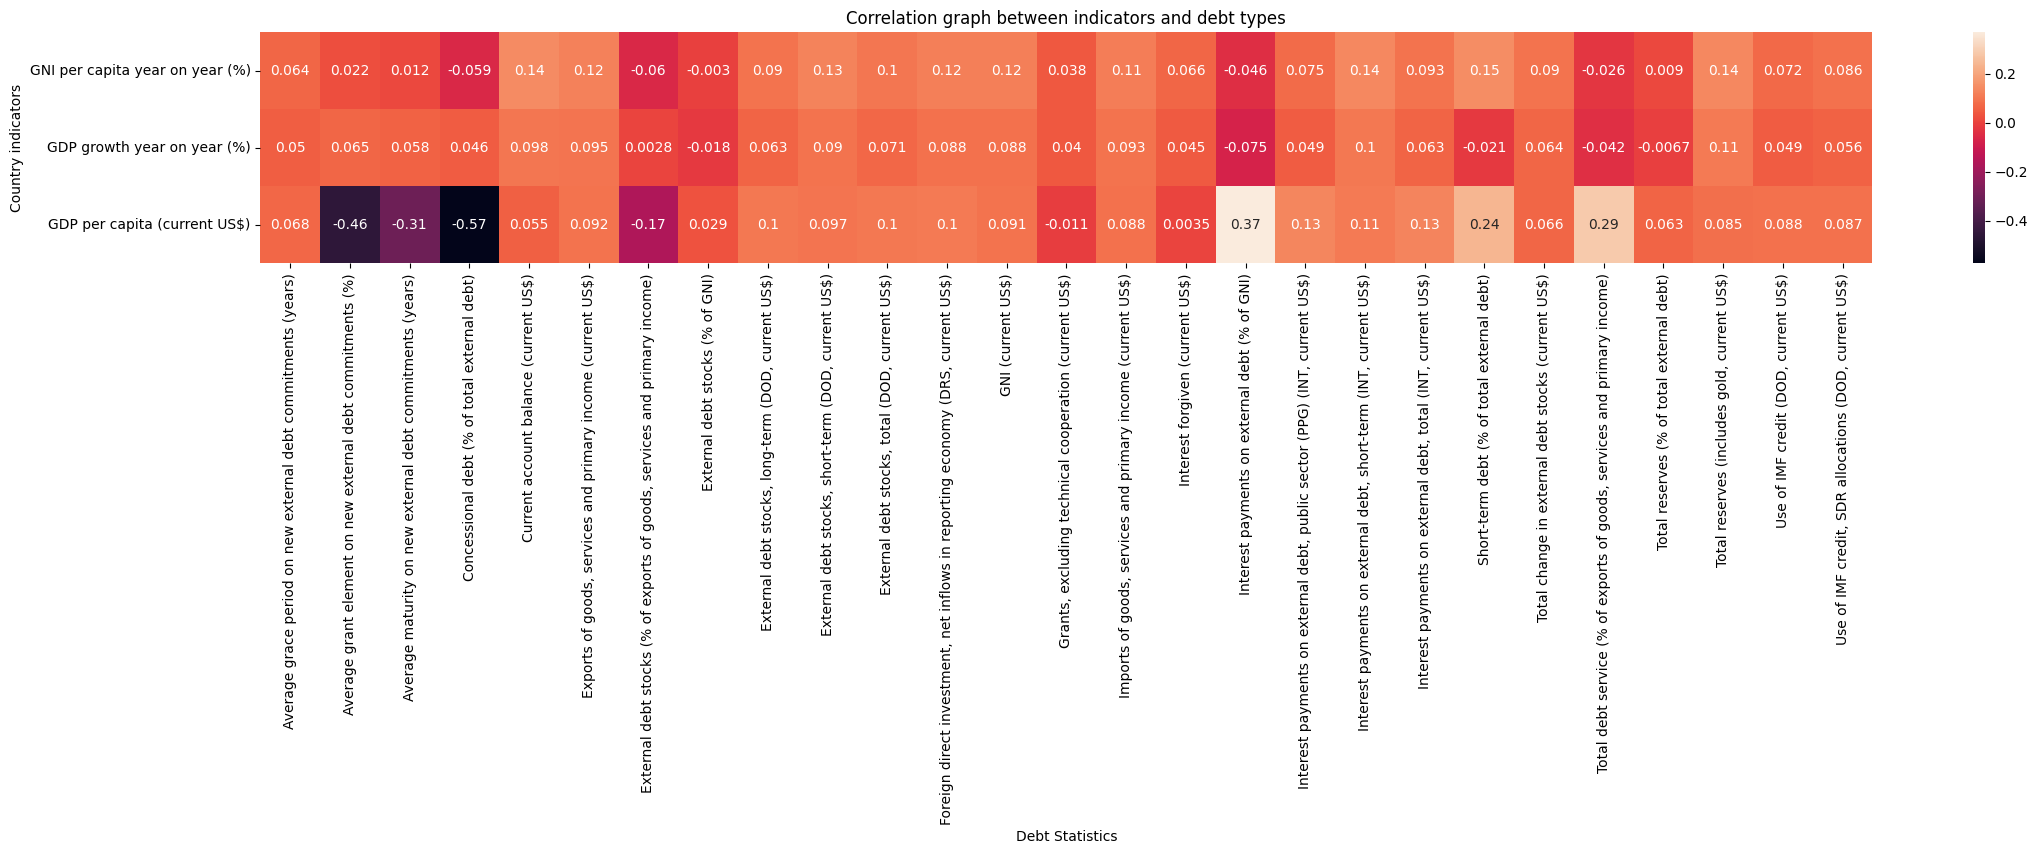

In [49]:
# Make an empty array that matches the dimensions of a the correlation table for an individual year so that we can add up the data
total_arr = []
# An array full of 21's (The total number of years) so that we can divide to get the average
total_nan_arr = []

# Fills in arrays with 0's or 21's
for num in range(30):
    total_arr.append(np.zeros(30))
    total_nan_arr.append(np.full(30, 21))

# Converts arrays to numpy arrays
total_arr = np.array(total_arr)
total_nan_arr = np.array(total_nan_arr)

# Loops through all years (2000 to 2020)
for curr_year in range(2000,2021):
    # Gets the correlation table for the current year then converts the dataframe to a numpy array
    curr_corr_table = get_corr_table_for_year(curr_year).to_numpy()
    
    # Sets the initial value of the row's index at 0
    row_index = 0 

    for row in curr_corr_table:
        # Sets the value of the current values index at 0
        value_index = 0
        
        for specific_comparison in row:

            # If the value is not empty (denoted in the array by NaN) we add it to its corresponding correlation value
            if not math.isnan(specific_comparison):
                total_arr[row_index][value_index] += specific_comparison   
            
            else:
                # For every empty value we minus one from its corresponding averaging value as less numbers will be added to the total value of all the categories
                # We can use the row index and value index since the both arrays have the same dimensions
                total_nan_arr[row_index][value_index] -= 1
            
            value_index += 1

        row_index += 1

# Creates the final numpy array that excludes the corrrelation data between the types of debt so it is only compared with the indicators
final_arr = []
for final_i in range(3):
    final_arr.append(total_arr[final_i]/total_nan_arr[final_i])

final_arr = np.array(final_arr)

# Gets the index for the new numpy array
index = get_corr_table_for_year(2000).index
total_corr = pd.DataFrame(data=final_arr[:,3:],columns=index[3:],index=index[:3])

# Plots the Correlation graph as a heatmap to see the stronger and weaker correlations
plt.figure(figsize=(26,3))
sns.heatmap(total_corr, annot=True)

plt.title('Correlation graph between indicators and debt types')
plt.ylabel('Country indicators')
plt.xlabel("Debt Statistics")
plt.show()

Standarised correlation

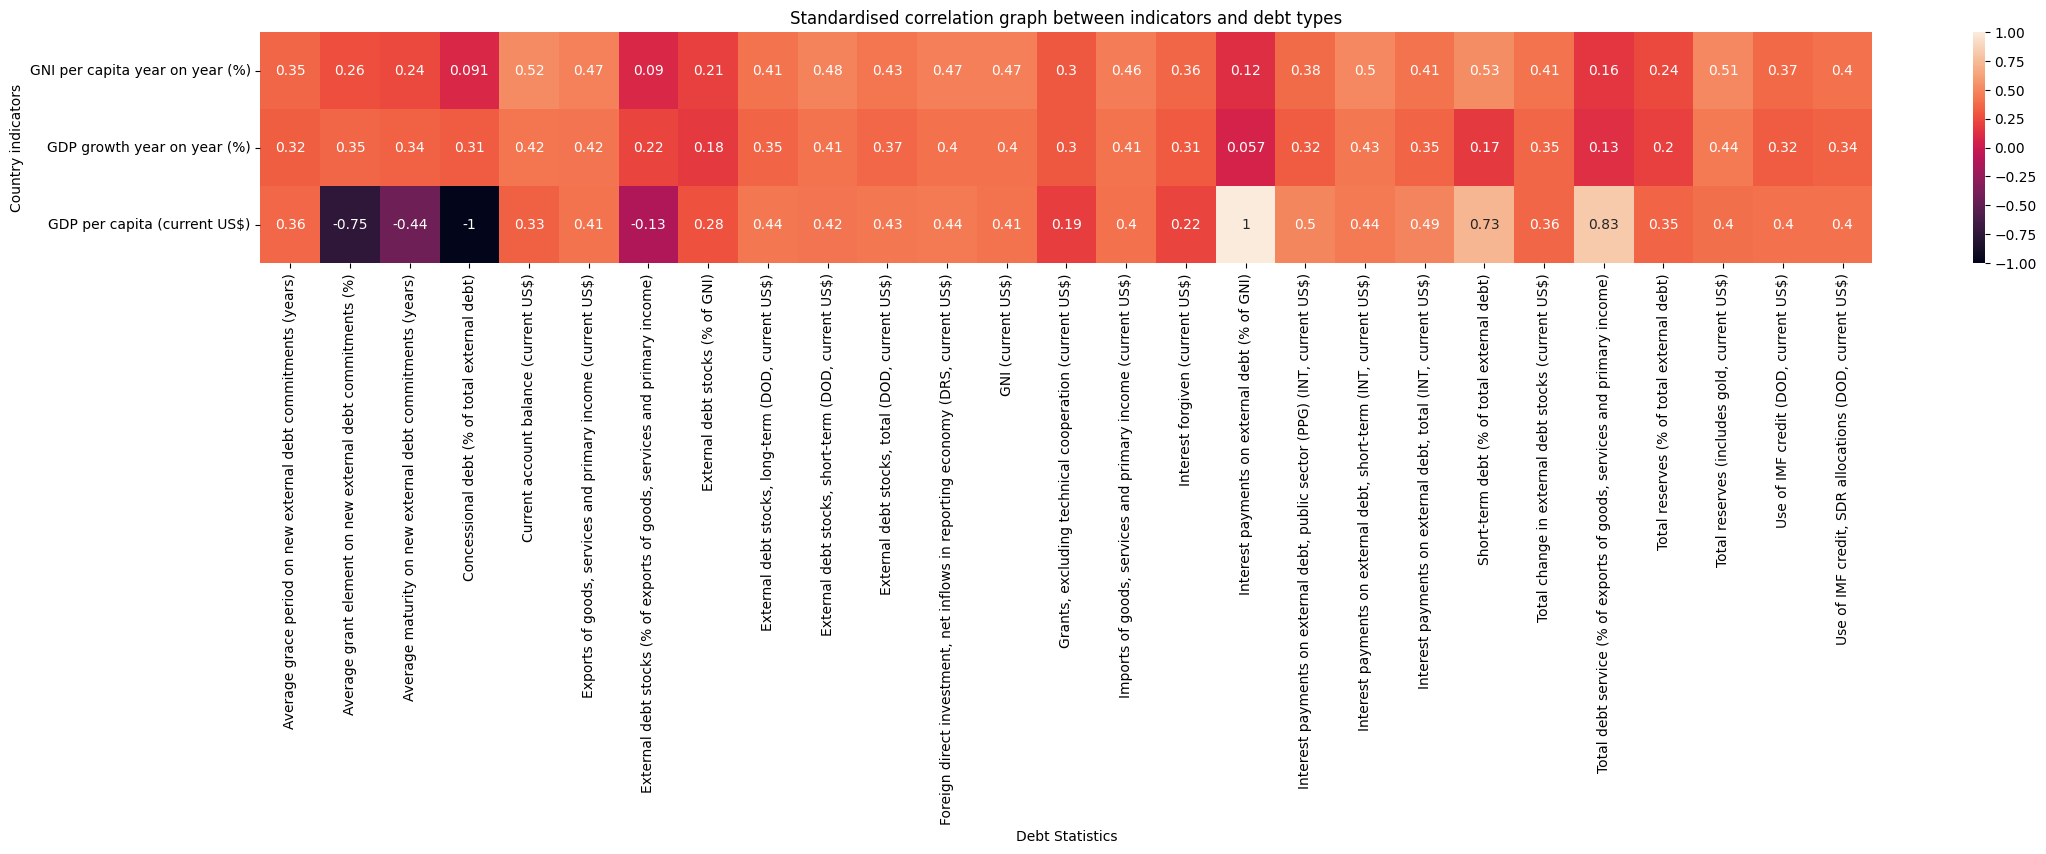

In [12]:
# Normalises the data so that it will have a mean at 0 and a standard deviation of 1

# Data needs to be flattened so that it can be scaled relative to all the data not just he ones in the given field
flattened_corr = total_corr.values.flatten()

scaler = StandardScaler()
standardised_corr = scaler.fit_transform(flattened_corr.reshape(-1,1)).flatten()

# Scale to the range [-1, 1]
scaled_data = 2 * (standardised_corr - standardised_corr.min()) / (standardised_corr.max() - standardised_corr.min()) - 1
scaled_data2 = scaled_data.reshape(total_corr.shape)
scaled_data2 = pd.DataFrame(data=scaled_data2,columns=index[3:],index=index[:3])


# Plots the data
plt.figure(figsize=(26,3))
sns.heatmap(scaled_data2, annot=True)
plt.title('Standardised correlation graph between indicators and debt types')
plt.ylabel('Country indicators')
plt.xlabel("Debt Statistics")
plt.show()

Barcharts comparing debt statistics between countries

In [55]:
# Function to generate a bar chart for selected countries and a specific debt category
def get_barchart(countries):
    # Dictionary to store data for the bar chart
    barchart_data = {}

    # Extract the information for the first country in the list
    country1 = countries[0]
    countries_index = country1[0]  # Assumes the first country's index is used

    # Loop through each debt category for the first country
    for category in country1[1]:
        # Loop through each country in the list
        for country in countries:
            # Populate the barchart_data dictionary with values for each country and category
            barchart_data[country[2]] = country[1][category]

            # Check if it's the last country in the list
            if country == countries[-1]:
                # Create a DataFrame from the barchart_data dictionary
                df = pd.DataFrame(barchart_data, index=countries_index)

                # Plot a bar chart using the DataFrame
                df.plot.bar(xlabel='Category', ylabel=category, rot=0, figsize=(12, 6),
                             title=f"Bar chart of the {category.lower()} from 2000 to 2020")

                # Reset the barchart_data dictionary for the next iteration
                barchart_data = {}

# List of selected country codes
selected_countries_codes = ['SDN', 'AFG', 'ALB', 'BOL', 'ZWE', 'TGO', 'TKM']

# List to store input values for the barchart
barchart_input = []

# Retrieve input values for each selected country code
for country_code in selected_countries_codes:
    input_value = split_data_up(country_code)
    barchart_input.append(input_value)

# Call the function to generate the barchart
# get_barchart(barchart_input)

pass


Cluster Analysis

/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/si

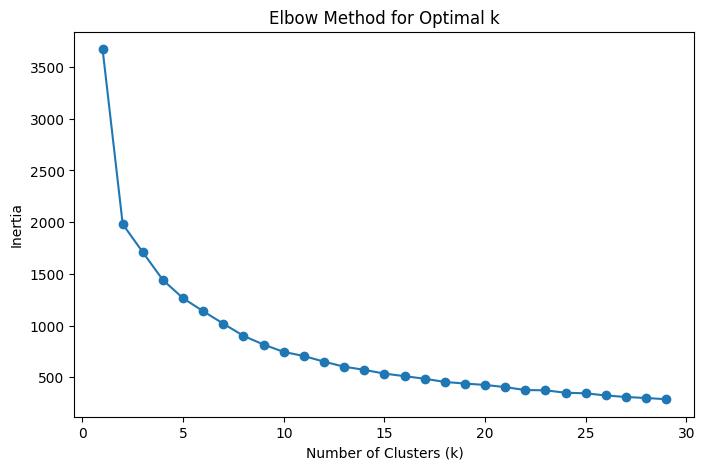

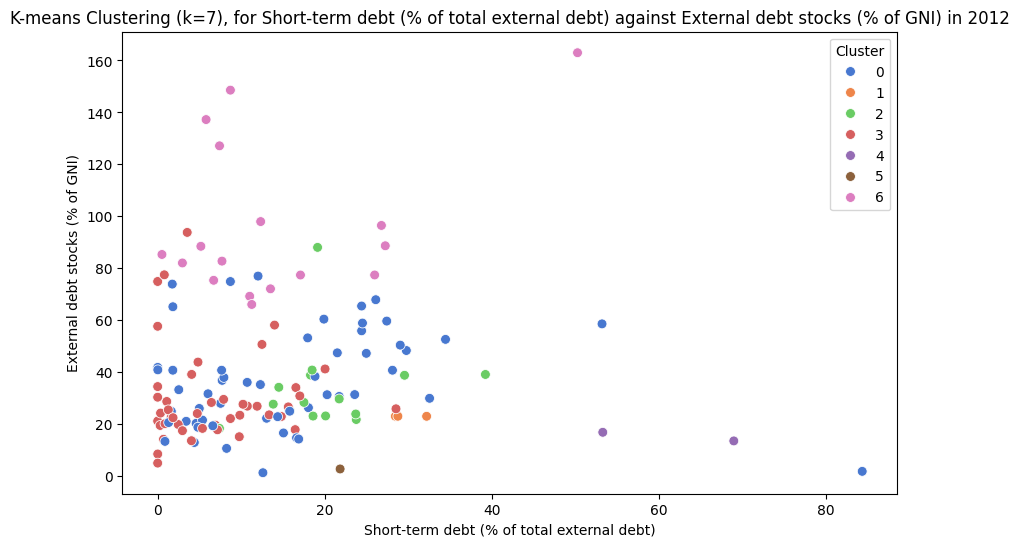

/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/si

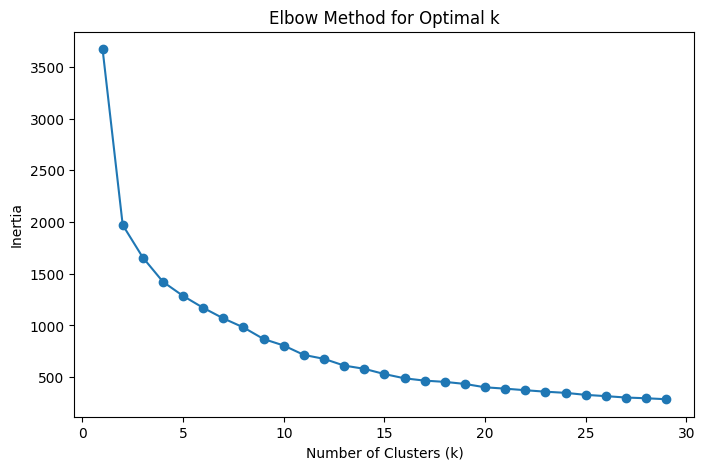

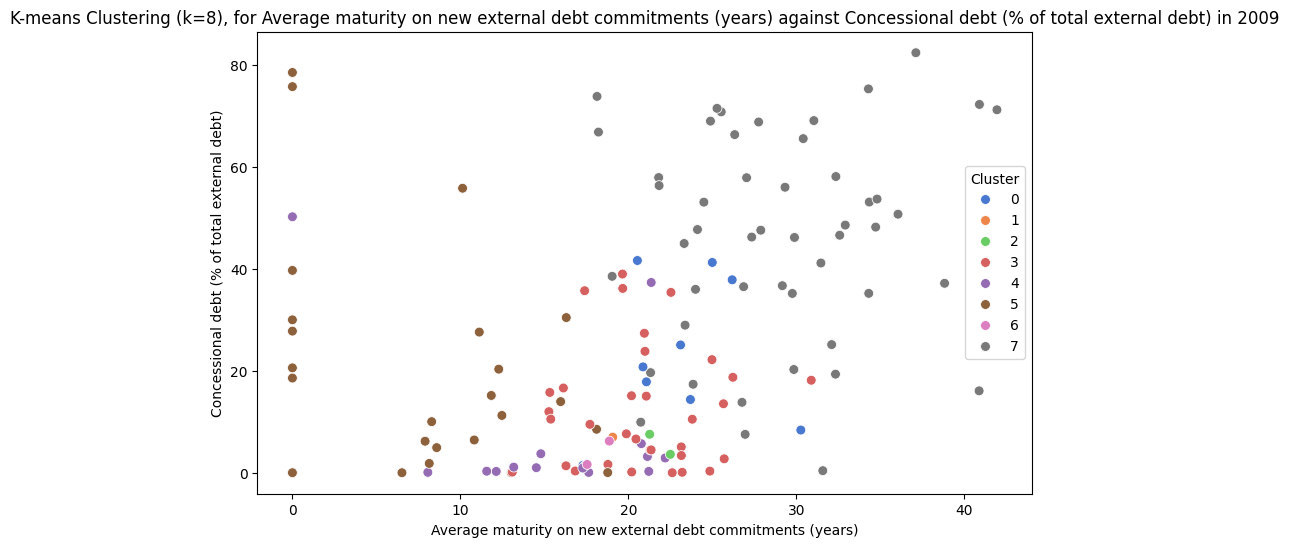

/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Volumes/PYTHON/international_debt_analysis/.venv/lib/python3.11/si

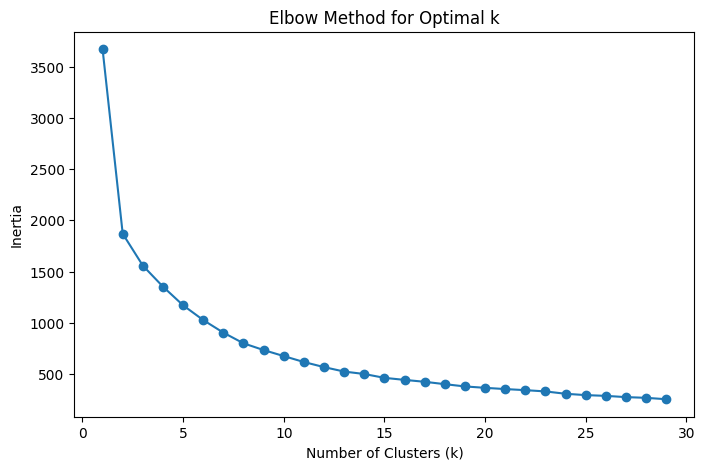

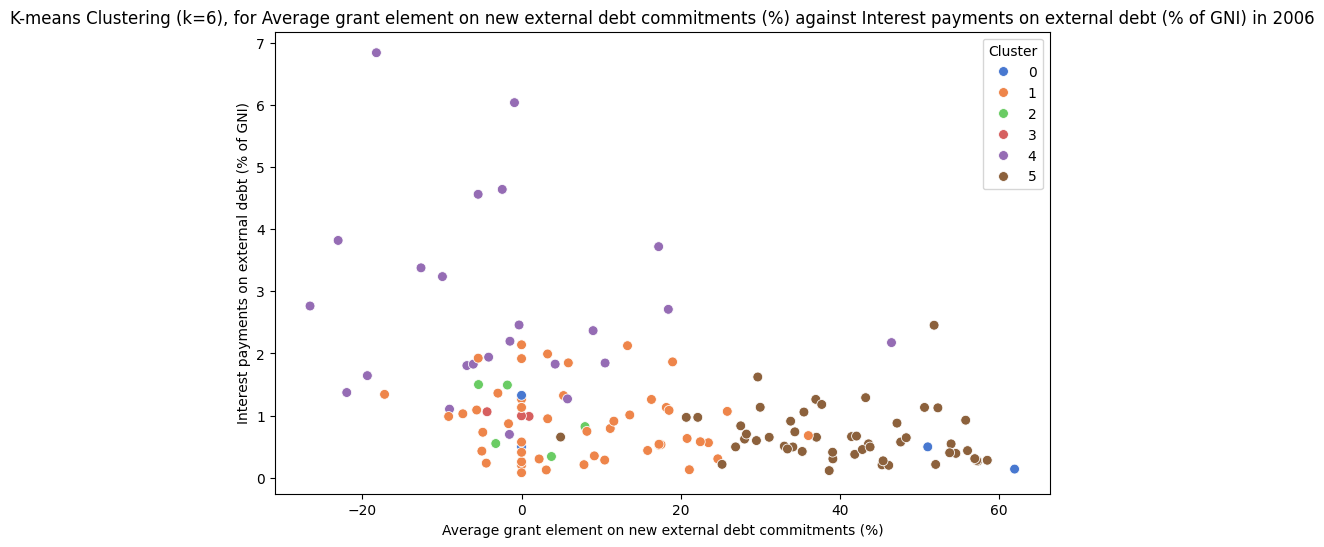

In [62]:


def get_cluster(feature_1,feature_2,_year):

    df_cluster_data = get_rearranged_year_data(all_years_data,_year)

    # Replace 'nan' with actual NaN values
    df_cluster_data.replace('nan', np.nan, inplace=True)

    # Convert non-numeric values to NaN
    df_cluster_data = df_cluster_data.apply(pd.to_numeric, errors='coerce')

    # Handle missing values by imputing with the mean of each column
    df_cluster_data_filled = df_cluster_data.fillna(df_cluster_data.mean())

    # Standarise the data
    scaled_data = scaler.fit_transform(df_cluster_data_filled)

    # Determine the optimal number of clusters using the Elbow Method
    inertia = []
    for n_clusters in range(1, 30):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Method
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 30), inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

    # Based on the Elbow Method, choose the optimal number of clusters (k) through this loop

    for intertia_value in inertia:
        # The optimal of k is taken to be the first value such that intertia of that value is a quater of the intital inertia
        if intertia_value <= 0.25 * inertia[0]:
            optimal_k = inertia.index(intertia_value)
            break


    # Apply K-means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_cluster_data_filled['Cluster'] = kmeans.fit_predict(scaled_data)

    # Visualize the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_1, y=feature_2, hue='Cluster', data=df_cluster_data_filled, palette='muted', s=50)
    plt.title(f'K-means Clustering (k={optimal_k}), for {feature_1} against {feature_2} in {_year}')
    plt.show()

get_cluster('Short-term debt (% of total external debt)','External debt stocks (% of GNI)',2012)
get_cluster('Average maturity on new external debt commitments (years)','Concessional debt (% of total external debt)',2009)
get_cluster('Average grant element on new external debt commitments (%)','Interest payments on external debt (% of GNI)',2006)